In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# GET THE DATAFRAME.

import pandas as pd

df_path = "../../data/raw/debunking_review.tsv"
df = pd.read_csv(df_path, sep="\t")

In [15]:
# PERFORM DATA PROCESSING (LEMATIZATION ETC), GET TFIDF SCORES AND FEATURE NAMES.

from eppi_text_classification import (
    get_features_and_labels,
    get_tfidf_and_names,
)

word_features, labels = get_features_and_labels(df)

tfidf_scores, feature_names = get_tfidf_and_names(word_features)

In [16]:
# PERFORM AN OPTUNA HYPERPARAMETER SEARCH, CAN CHANGE THE SEARCH SPACE IN OPT.PY

from eppi_text_classification import OptunaHyperparameterOptimisation

optimiser = OptunaHyperparameterOptimisation(
    tfidf_scores,
    labels,
    "LGBMClassifier",
    n_trials_per_job=3,
    n_jobs=-1,
    nfolds=3,
    num_cv_repeats=1,
    # db_url=f"sqlite:////mnt/tmp/optuna.db", #Use this one on Azure
    db_url=None,
)

optimiser.delete_optuna_study("lgbm_binary")
best_params = optimiser.optimise_hyperparameters(study_name="lgbm_binary")

sqlite:////Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/optuna.db


[I 2024-09-10 17:42:05,577] A new study created in RDB with name: lgbm_binary
[I 2024-09-10 17:42:10,069] Trial 1 finished with value: 0.9152436369393976 and parameters: {'max_depth': 8, 'min_child_samples': 15, 'learning_rate': 0.21030120308969755, 'num_leaves': 5, 'n_estimators': 103, 'min_split_gain': 0.009149138299107058, 'min_child_weight': 2.6246507587669235e-06, 'reg_alpha': 0.38754349722480813, 'reg_lambda': 1.0285950164213769e-05}. Best is trial 1 with value: 0.9152436369393976.
[I 2024-09-10 17:42:10,889] Trial 2 finished with value: 0.7622439990996212 and parameters: {'max_depth': 4, 'min_child_samples': 24, 'learning_rate': 0.3754818395376641, 'num_leaves': 8, 'n_estimators': 125, 'min_split_gain': 1.0587747495542518e-05, 'min_child_weight': 0.0033733949460549467, 'reg_alpha': 0.0002936654257399595, 'reg_lambda': 0.06791152389130495}. Best is trial 1 with value: 0.9152436369393976.
[I 2024-09-10 17:42:11,599] Trial 10 finished with value: 0.7893848652474476 and parameters: 

In [17]:
# FIT THE MODEL

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

# model = LGBMClassifier(**best_params)

model = LGBMClassifier(
    verbosity=-1,
    boosting_type="gbdt",
    max_depth=4,
    min_child_samples=30,
    learning_rate=0.1245928917280467,
    num_leaves=6,
    n_estimators=2455,
    subsample_for_bin=20000,
    subsample=1.0,
    objective="binary",
    scale_pos_weight=27,
    min_split_gain=2.52381000405986e-06,
    min_child_weight=5.544840854157574e-06,
    reg_alpha=3.629909607712911e-05,
    reg_lambda=3.671749546766942e-05,
    n_jobs=1,
)

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_scores, labels, test_size=0.333, stratify=labels, random_state=8
)

model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.1245928917280467, max_depth=4,
               min_child_samples=30, min_child_weight=5.544840854157574e-06,
               min_split_gain=2.52381000405986e-06, n_estimators=2455, n_jobs=1,
               num_leaves=6, objective='binary',
               reg_alpha=3.629909607712911e-05,
               reg_lambda=3.671749546766942e-05, scale_pos_weight=27,
               subsample_for_bin=20000, verbosity=-1)

In [18]:
# CREATE ROC CURVE TO SELECT THRESHOLD p

from eppi_text_classification.predict import predict_scores
from eppi_text_classification.plotly_roc import plotly_roc

y_test_pred_probs = predict_scores(model, X_test)
plotly_roc(y_test, y_test_pred_probs)

In [19]:
# GET MODEL THRESHOLD FOR CHOSEN TPR, MAKE PREDICTIONS

from eppi_text_classification.predict import (
    get_raw_threshold,
    raw_threshold_predict,
)

threshold = get_raw_threshold(model, X_test, y_test, target_tpr=1)

y_test_pred = raw_threshold_predict(model, X_test, threshold)
y_train_pred = raw_threshold_predict(model, X_train, threshold)

In [27]:
from eppi_text_classification import binary_train_valid_confusion_plotly

binary_train_valid_confusion_plotly(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    postive_label="Included",
    negative_label="Excluded",
)

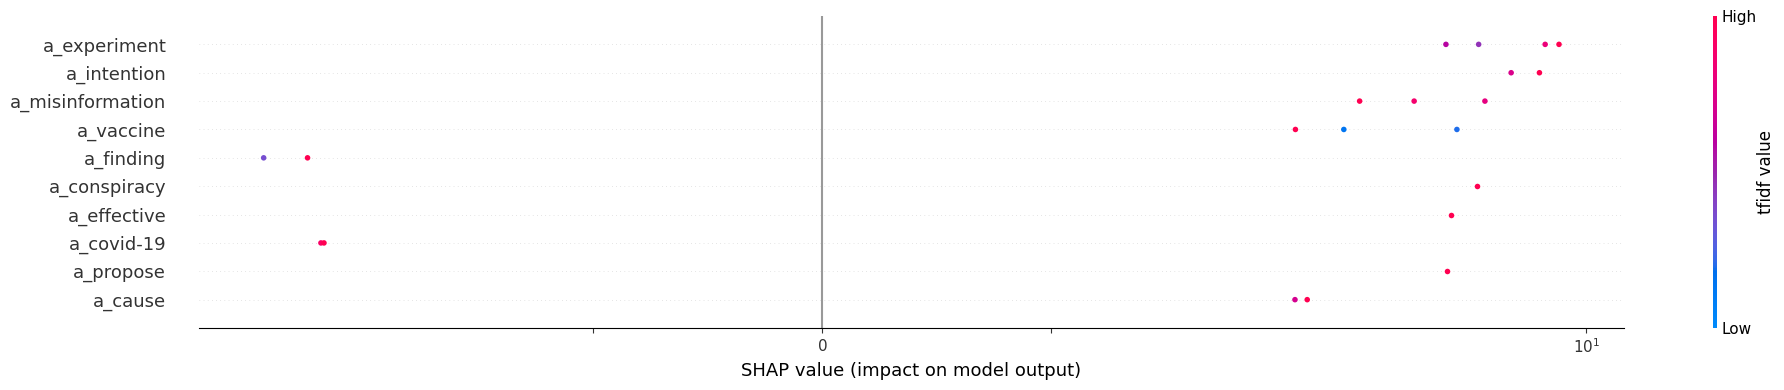

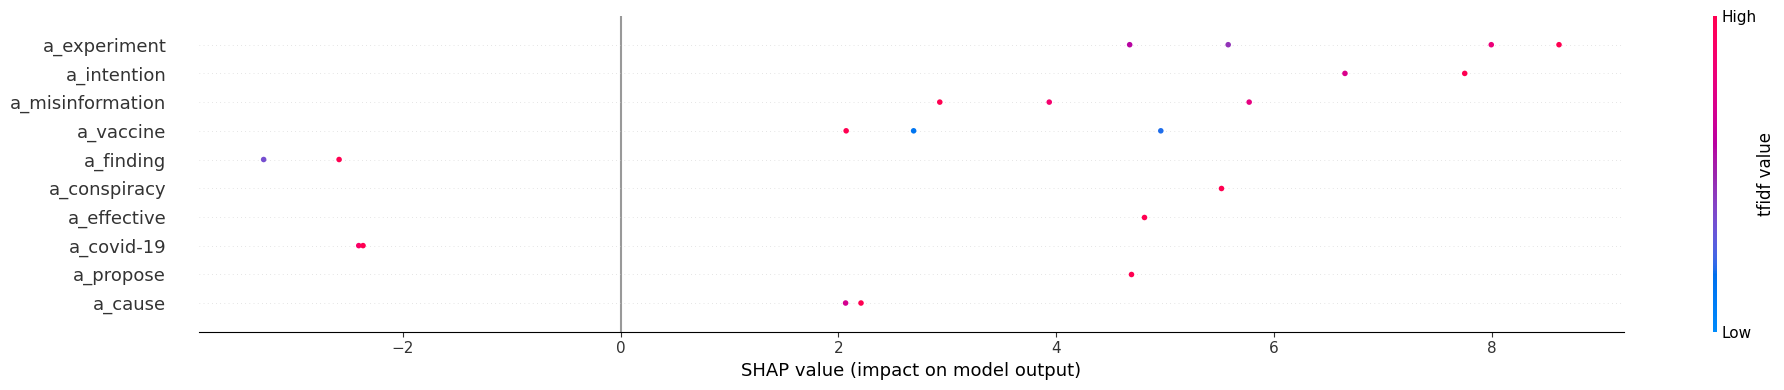

In [24]:
from eppi_text_classification import ShapPlotter

shap_plotter = ShapPlotter(
    model,
    X_test[:10],
    feature_names,
)
dot_plot = shap_plotter.dot_plot(num_display=10)
dot_plot.show()
dot_plot = shap_plotter.dot_plot(num_display=10, log_scale=False)
dot_plot.show()
bar_plot = shap_plotter.bar_chart()

Truth: 0
Prediction: [0]
Shap value: -20.17600657675702
Prediction score: [-20.17600658]


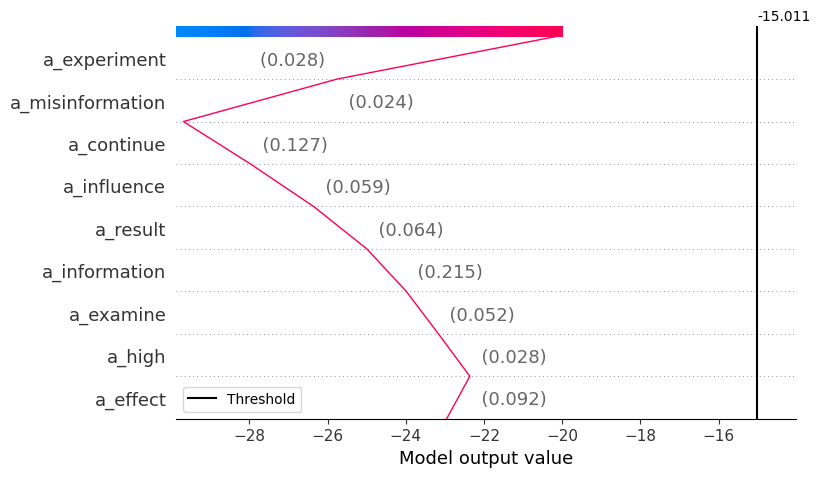

Truth: 0
Prediction: [1]
Shap value: -4.616688695926907
Prediction score: [-4.6166887]


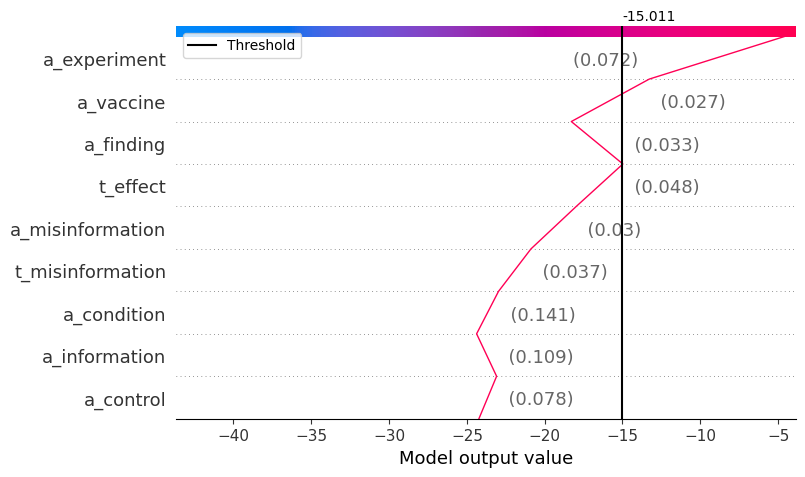

Truth: 0
Prediction: [0]
Shap value: -26.435449852322588
Prediction score: [-26.43544985]


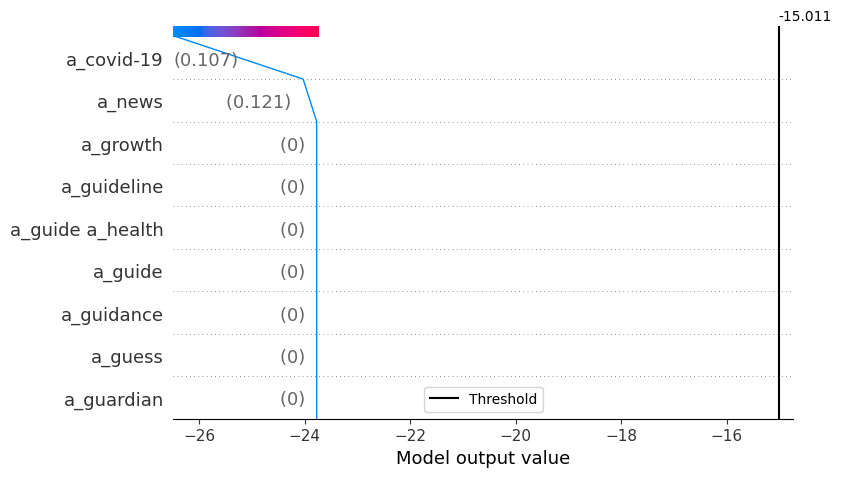

Truth: 0
Prediction: [0]
Shap value: -25.180047085786168
Prediction score: [-25.18004709]


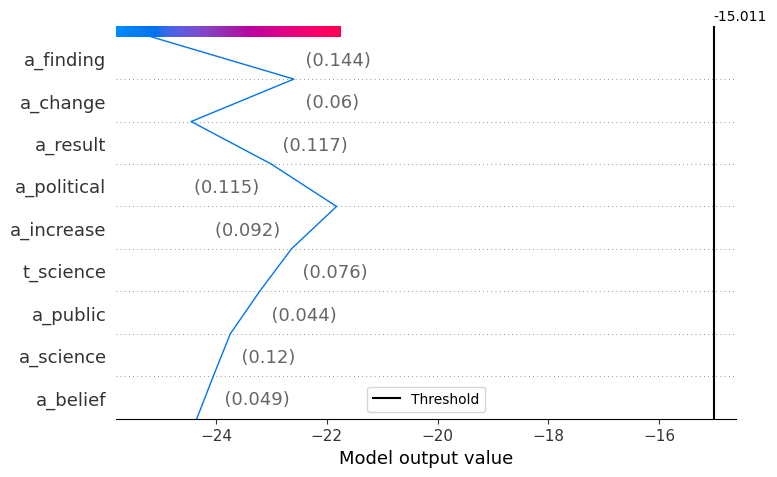

Truth: 0
Prediction: [1]
Shap value: -14.584450806452827
Prediction score: [-14.58445081]


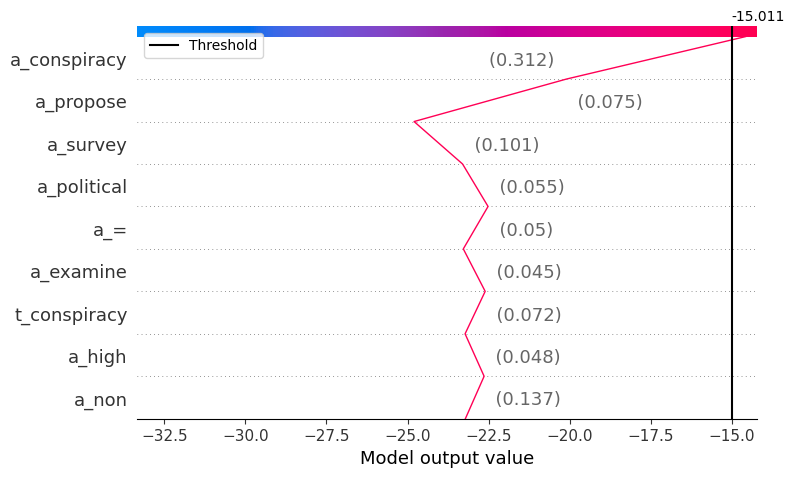

In [25]:
import numpy as np

shap_plotter = ShapPlotter(model, X_test[0:10], feature_names)

for i in range(5):
    print(f"Truth: {y_test[i]}")
    print(f"Prediction: {raw_threshold_predict(model, X_test[i], threshold)}")
    print(
        f"Shap value: {shap_plotter.shap_values[i].sum() + shap_plotter.expected_value}"
    )
    print(f"Prediction score: {predict_scores(model, X_test[i])}")
    decision_plot = shap_plotter.single_decision_plot(
        threshold=threshold, index=i, num_display=10, log_scale=False
    )
    decision_plot.show()